In [1]:
import pandas as pd
import numpy as np
from ipywidgets import interact
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import matplotlib
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')
from tqdm.auto import tqdm

In [2]:
transactions = pd.read_csv("../data/dunnhumby_The-Complete-Journey/dunnhumby - The Complete Journey CSV/transaction_data.csv")

We analyzed how much people spend on shopping and how that value changes over time.

In [3]:
def plot_trend(x, y, xlabel, ylabel, title, std=None):
    plt.figure(figsize=(10,8))
    
    plt.plot(x, y, label="Actual values")
    
    reg = LinearRegression()
    x_reg = x.to_numpy().reshape(-1, 1)
    reg.fit(x_reg, y)
    plt.plot(x, reg.predict(x_reg), label="Linear trend")
    if std is not None:
        plt.fill_between(monthly.index, monthly - std, monthly + std, alpha=0.2)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

## Weekly spending

First we take a look at the mean household spending each week and see how it varies over time.

In [4]:
# we compute mean 
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum().groupby("WEEK_NO").mean().sort_index()

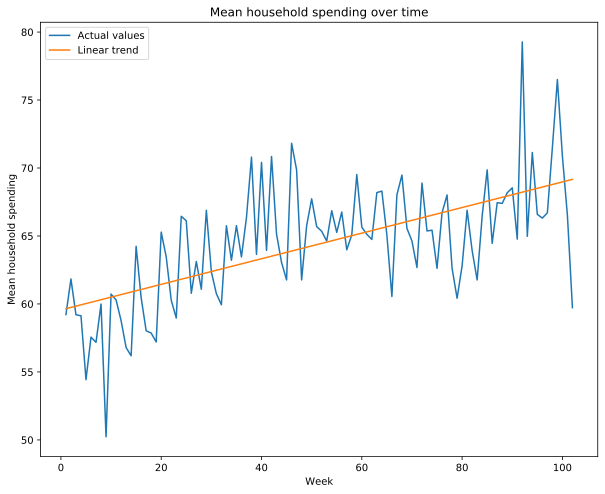

In [5]:
plot_trend(weekly.index, weekly, "Week", "Mean household spending", "Mean household spending over time")

There is a high deviation between subsequent weeks, but we can see that the sales are overall increasing over time. The linear regression shows a rising tendency.

## Monthly spending
To deal with the very high variance between weeks, we will now look at the spending within a longer time interval - a month.

In [9]:
# compute an approximation of which month we are in (assuming all months are 30 days)
transactions["MONTH"] = (np.floor(transactions["DAY"] / 30) + 1).apply(int)

In [10]:
# Now we compute mean household spending in each month
monthly = transactions.groupby(["household_key", "MONTH"])["SALES_VALUE"].sum().reset_index().groupby("MONTH")["SALES_VALUE"].mean()

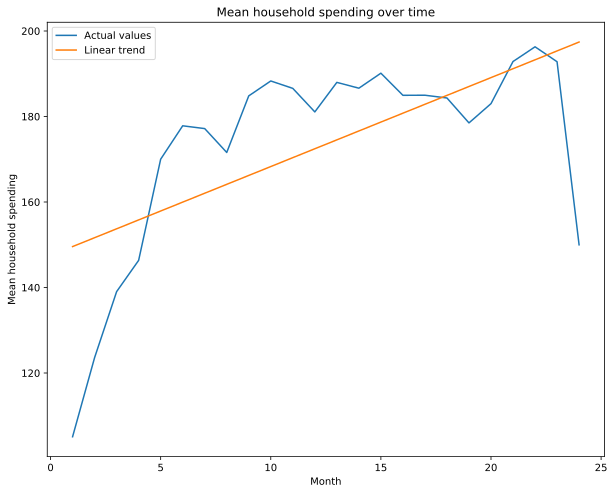

In [12]:
plot_trend(monthly.index, monthly, "Month", "Mean household spending", "Mean household spending over time")

The plot is much smoother and we can indeed see an increasing trend, especially at the very beginning (in the first half of the fist year). After half a year the trend seems to still be rising, however it slows down a lot in comparison to the first months.

## Some explanation
It is important to note how we should understand the data we have: we have sales data for a specific set of stores. The fact that we see an increase in spending over time what we really see is increase in store's sales. It is possible that it is due to the people startin o spend more money, but it is equally possible that they are spending the same amount, but choosing the stores we have access to more frequently instead of other stores that are not in this database. In fact the big rise in the first half a year could be explained by the store starting a marketing campaign - the small sales in the beginning could mean new customers starting to sometimes go to this stores and the rapid increase could be the result of them starting to choose it more and more often over other stores due to marketing. The slowdown afterwards may be due to saturation - most interested customers already have started to frequent these stores often and they don't change their habits that much anymore.

In [13]:
monthly_sales = transactions.groupby(["MONTH"])["SALES_VALUE"].sum()

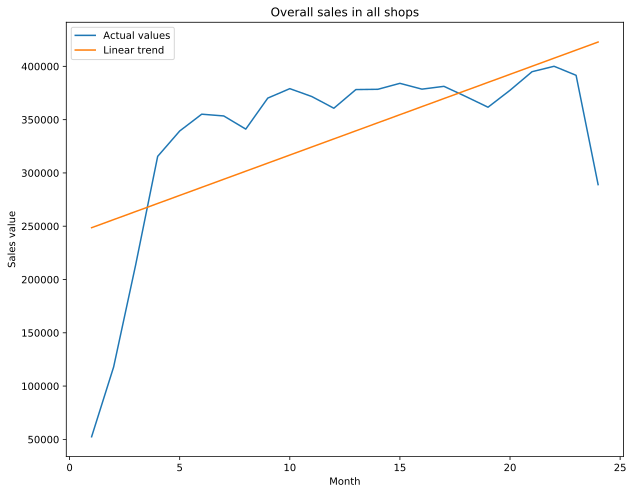

In [14]:
plot_trend(monthly_sales.index, monthly_sales, "Month", "Sales value", "Overall sales in all shops")

Looking at overall sales in all the shops seems to confirm our hypothesis. Both plots are quite similar so the spending increase is likely not (primarily) caused by for example buying more expensive products, but it seems the primary cause is people just buying more. Which is likely caused by the shop being more recognizable and becoming the go-to store for more and more people.

## Individual trends

However people are not a namelss mass but a group of individuals. The mean household spending seems to be rising, but does that mean that all the people are spending more and more? Let's find out.

In [15]:
def find_absolute_coef(data):
    data = data.rename("count").sort_index().reset_index()
    model = LinearRegression()
    X = data["WEEK_NO"].to_numpy() / 102
    y = data["count"].to_numpy()
    # we fit a Linear Regression to find a line best fitting the change in spending over time
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    return model.coef_[0][0]

In [16]:
def find_percentage_change(data):
    data = data.rename("count").sort_index().reset_index()
    model = LinearRegression()
    X = data["WEEK_NO"].to_numpy() / 102
    y = data["count"].to_numpy()
    # we fit a Linear Regression to find a line best fitting the change in spending over time
    model.fit(X.reshape(-1,1),y.reshape(-1,1))
    
    # we now compute the percentage change    
    return (100 * (model.coef_[0][0]) / model.intercept_[0])

In [17]:
weekly = transactions.groupby(["household_key", "WEEK_NO"])["SALES_VALUE"].sum()

We now try to fit a Linear Regression model to the weekly spending of each household. The fitted line represents a 'trend' in the spending of the household - if the line is going upwards it means the household is spending more and if it is downwars the household is likely to started saving. A horizontal line means the spending stays more or less the same.

We will compute a percentage spending change - we fit the line to weekly spending (to avoid the high variance, the line is an approximation of a long term tendency) and assume the line's height in the first week is the starting value and its height in the last week is the final value and compute the percentage difference between the two.

In [18]:
absolute_trends = weekly.groupby("household_key").apply(find_absolute_coef)

In [19]:
percentage_trends = weekly.groupby("household_key").apply(find_percentage_change)

We have dropped some outliers from the data which were mostly households that did very few transactions. Given too few transactions the trend approximation was too imprecise to give good results.

In [20]:
absolute_trends = absolute_trends[absolute_trends.abs() < 500]

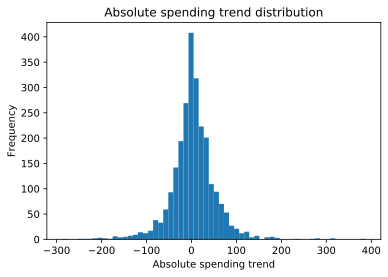

In [22]:
absolute_trends.plot.hist(bins=60, log=False)
plt.title("Absolute spending trend distribution")
plt.xlabel("Absolute spending trend")
plt.show()

The absolute spending trend is just the coefficient of the linear trend - it is very dependent on the initial value. If someone was spending 200k in the beginning and in the end they are spending 210k, the coefficient would be the same as in the case someone was spending 10k and started spending 20k, but in fact these changes are drastically different (5% vs 100% increase).

That is why we will now analyse the percentage change described earlier - it is a better metric in terms of habits. Because a 2x is very different from a 5% change.

In [84]:
100 * (percentage_trends.abs() > 1000).sum() / len(percentage_trends)

3.0

We checked that only 3% of samples are extreme outliers (with percentage bigger than 1000%), so we skipped them in the histograms to make them more readable. They are likely caused by households doing not too many transactions and the trend approximation being imprecise with too few samples.

In [23]:
percentage_trends = percentage_trends[percentage_trends.abs() < 1000]

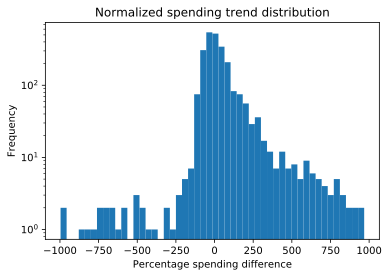

In [26]:
percentage_trends.plot.hist(bins=50,log=True)
plt.title("Normalized spending trend distribution")
plt.xlabel("Percentage spending difference")
plt.show()

A positive value means the spending has been increased - for example 100% means the spending is now twice as at the beginning, 0% means no change and -50% means the spending has decreased by 50% since the beginning.

Values smaller then -100% may look suspicious - what they represent is samples where there wasn't too much data so the approximated spending trend is indicating that at the end of the period they would be spending negative amounts which is of course illogical.
We can however treat these values just as big negative values, because these customers were spending much less over time.

In [32]:
print("The median percentage difference is " + str(np.round(np.median(percentage_trends), 2)) + "%, but the average is " + str(np.round(np.mean(percentage_trends), 2)) + "%")

The median percentage difference is 2.79%, but the average is 32.45%


We can see that the mean is much bigger than the median - there are some people that have greatly increased their spending, but most people actually increased only slightly.

In [56]:
nochange = np.round(100.0 * (percentage_trends.abs() < 10).sum() / len(percentage_trends), 2)
print(str(nochange) + "% of households have not changed their spending by more than 10%")

12.41% of households have not changed their spending by more than 10%


In [63]:
incr = np.round(100.0 * (percentage_trends > 10).sum() / len(percentage_trends), 2)
incr2 = np.round(100.0 * (percentage_trends > 50).sum() / len(percentage_trends), 2)
print(str(incr) + "% of households have increased their spending by 10% or more")

45.94% of households have increased their spending by 10% or more


In [59]:
decr = np.round(100.0 * (percentage_trends < -10).sum() / len(percentage_trends), 2)
print(str(decr) + "% of households have decreased their spending by 10% or more")

41.65% of households have decreased their spending by 10% or more


We can see that most people have indeed increased their spending, but almost as many have actually decreased it.

